In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11e0da210>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [13]:
station_first_row = session.query(Station).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11e0ca810>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [14]:
# latest day
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [97]:
# Calculate the date 1 year ago from the last data point in the database
last_day = dt.date(2017,8,23) - dt.timedelta(days=365)
last_day

datetime.date(2016, 8, 23)

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_data = session.query(Measurement.date,Measurement.prcp).\
         filter(Measurement.date >= "2016-08-23").\
         filter(Measurement.date <= "2017-08-23").all()

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
plotdata = pd.DataFrame(prcp_data, columns = ["Date","Prcp"])
# df.set_index('Date', inplace=True, )
plotdata.set_index('Date', inplace=True)
# Sort the dataframe by date
plotdata.head()

,Prcp
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


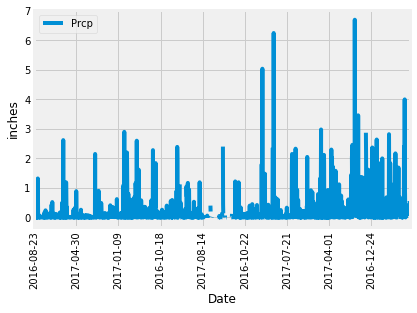

In [52]:
# Use Pandas Plotting with Matplotlib to plot the data
plotdata.plot()
plt.ylabel('inches')
fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
plotdata.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [24]:
# Design a query to show how many stations are available in this dataset?
sel = [func.count(Station.station)]
station_count = session.query(*sel).all()
station_count

[(9)]

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.station)]
station_dt = session.query(*sel).group_by(Measurement.station).\
             order_by(func.count(Measurement.station).desc()).all()
station_dt

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs)]
temp_dt = session.query(*sel).all()
temp_dt

[(53.0, 87.0)]

In [27]:
# average temperature of the most active station
sel = [func.avg(Measurement.tobs)]
temp_avg = session.query(*sel).filter(Measurement.station == "USC00519281").all()
temp_avg

[(71.66378066378067)]

In [28]:
# Choose the station with the highest number of temperature observations.
# Sort the result by stock name
sel = [Measurement.station, 
       func.count(Measurement.tobs)]
maxst = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
maxst

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram\
results = session.query(Measurement.date,Measurement.tobs).\
         filter(Measurement.date >= "2016-08-23").\
         filter(Measurement.date <= "2017-08-23").\
         filter(Measurement.station == "USC00519281").all()

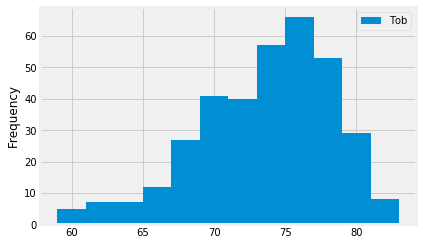

In [32]:
df12 = pd.DataFrame(results, columns = ["Date","Tob"])
df12.plot.hist(by="Date",bins=12)

## Bonus Challenge Assignment

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps('2017-04-02', '2017-04-12')
results

[(67.0, 74.46478873239437, 82.0)]

In [35]:
# Plot the results from your previous query as a bar chart. 
travel_df = pd.DataFrame(results,columns=["Tmin","Avg","Tmax"])

In [36]:
ptps = list(np.ravel(results))

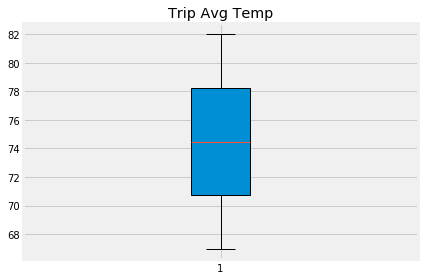

In [37]:
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = travel_df["Tmax"] - travel_df["Tmin"]

fig, ax = plt.subplots()

x = range(len(ptps))
ax.boxplot(ptps, patch_artist=True)
ax.set_title('Trip Avg Temp')
fig.tight_layout()
plt.show()

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, 
# and elevation
results = session.query(
         Station.station,
         func.sum(Measurement.tobs),
         Station.name, 
         Station.latitude,
         Station.longitude,
         Station.elevation).\
         filter(Measurement.date >= "2017-04-02").\
         filter(Measurement.date <= "2017-04-12").\
         group_by(Station.station).\
         order_by(func.sum(Measurement.tobs).desc()).all()
import pprint
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(results)

[('USC00519523',
  5287.0,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 5287.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281',
  5287.0,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00518838',
  5287.0,
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6),
 ('USC00517948', 5287.0, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00516128',
  5287.0,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  5287.0,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00513117', 5287.0, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00511918',
  5287.0,
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9)]


In [69]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [70]:
daily_normals("01-01")[0]

(62.0, 69.15384615384616, 77.0)

In [40]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
sdate = date(2017, 4, 2)   
edate = date(2017, 4, 12)

# Use the start and end date to create a range of dates

delta = edate - sdate       # as timedelta

day_list = []

for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
# Stip off the year and save a list of %m-%d strings
    day = day.strftime("%m-%d")
    day_list.append(day)
    
day_list

['04-02',
 '04-03',
 '04-04',
 '04-05',
 '04-06',
 '04-07',
 '04-08',
 '04-09',
 '04-10',
 '04-11',
 '04-12']

In [85]:
date_df = pd.DataFrame(day_list, columns = ["Date"] )
date_df

,Date
0,04-02
1,04-03
2,04-04
3,04-05
4,04-06
5,04-07
6,04-08
7,04-09
8,04-10
9,04-11


In [65]:
# calculate the normals for each date string and append the results to a list.
normal_list = []

for date in day_list:
    normal_list.append(daily_normals(date)[0])
    
normal_list

[(53.0, 71.82142857142857, 79.0),
 (55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0)]

In [91]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normal_list,columns = ["temp_min","temp_avg","temp_max"])
final_normal = pd.concat([date_df, normal_df], axis=1)
final_normal

,Date,temp_min,temp_avg,temp_max
0,04-02,53.0,71.821429,79.0
1,04-03,55.0,72.228070,78.0
2,04-04,58.0,72.016393,78.0
3,04-05,61.0,72.288136,80.0
4,04-06,67.0,71.571429,77.0
5,04-07,63.0,71.105263,78.0
6,04-08,66.0,72.105263,77.0
7,04-09,62.0,71.614035,78.0
8,04-10,64.0,71.403509,79.0
9,04-11,65.0,72.491803,82.0


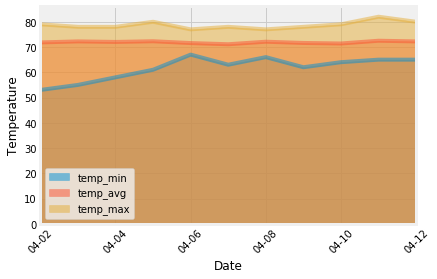

In [96]:
# Plot the daily normals as an area plot with `stacked=False`
ax = final_normal.plot.area(x='Date',stacked=False)
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.show()